In [1]:
import os, sys, argparse, importlib, time, inspect, json
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader
from importlib import reload
import winsound
import dill, wandb, json,os
import datetime as dt
# if wandblog:
#     !wandb login b5b917a9390932e56fccfcbff6f528ccd85c44bf

Notebook
GPU detected


In [2]:
with open('../from_config/exp_compare/base.json') as file:
    construct_dict = json.load(file)

construct_dict['group']='grad_tracker'

In [3]:
with tf.device('/cpu:0'):
    save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    model=tf.keras.models.load_model("../trained_models/KHop_base_max_3fsagz9i", options=save_options)
model.compile()
batch_size=512

In [4]:
# Setup Log 
wandblog=construct_dict["wandblog"]
# wandblog=0
# if wandblog:
#     import wandb
#     run = wandb.init(project = construct_dict["experiment"], entity = "chri862z", group=construct_dict["group"], config = construct_dict, reinit=True)
# #         wandb.run.name = construct_dict['model_name']+'_'+construct_dict['experiment_name']+'_'+str(wandb.run.id)
#     wandb.run.name = construct_dict['model_name']+'_'+str(wandb.run.id)
################################################
#   Load dataset                              #
################################################
#load dataset
os.chdir('../from_config')
import dev.testtraindata as dl
os.chdir('../model_eval')
print(os.getcwd())
graph_data=dl.graph_data

batch_size=100
epochs=1
os.chdir("C:\\Users\\chris\\Christian\\3YR-UNI\\Bachelor\\IceCube") ######!!!!!!
dataset=graph_data(n_steps=10, n_neighbors=31, restart=False, traintest='mix', i_test=1)
os.chdir('model_eval')


Not notebook
C:\Users\chris\Christian\3YR-UNI\Bachelor\IceCube\model_eval
Loading mixed data to memory


In [5]:
n_events=1000
loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_all = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [6]:
def i_path(x): return tf.zeros_like(x)

In [7]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1, num=m_steps+1)

In [8]:
def interpolate_data(inputx,alphas):
    baseline=i_path(inputx[0])
    alpha=tf.cast(alphas, tf.float64)
    alphas_x = alpha[tf.newaxis, :]
    # alphas_x
    baseline_x = tf.expand_dims(baseline, axis=2)
    input_x = tf.expand_dims(inputx[0], axis=2)
    delta = input_x - baseline_x
    # print(delta)
    inputs = baseline_x +  delta*alphas_x 
    return tf.transpose(inputs, perm=[2,0,1])

In [9]:
inputs, targets = next(loader_all)

In [10]:
event_nos=[]
for b in tqdm(range(len(dataset))):
    event_nos.append(dataset[b].y[3])

In [11]:
import pandas as pd
df_event=pd.DataFrame(event_nos)
df_event.to_csv('../predictions/explain_event_nos.csv')

In [12]:
event_nos

[6454399.0,
 3137789.0,
 3547157.0,
 12368794.0,
 10129673.0,
 10539122.0,
 12064225.0,
 3750614.0,
 4138463.0,
 3961566.0,
 18019284.0,
 12774071.0,
 1176636.0,
 3758558.0,
 9814282.0,
 12815351.0,
 4074945.0,
 623965.0,
 10529749.0,
 6067606.0,
 10776900.0,
 6243336.0,
 7369572.0,
 6986798.0,
 10315970.0,
 3740679.0,
 9885307.0,
 6486158.0,
 3769696.0,
 7531374.0,
 265737.0,
 972365.0,
 6518995.0,
 1060682.0,
 467058.0,
 1287815.0,
 4327259.0,
 3084190.0,
 9276342.0,
 6648602.0,
 127046.0,
 12561548.0,
 3423544.0,
 9148819.0,
 3739725.0,
 3894836.0,
 1450372.0,
 10109831.0,
 3551151.0,
 671643.0,
 6369666.0,
 6907776.0,
 7282795.0,
 7556705.0,
 4528439.0,
 10013463.0,
 9023032.0,
 13141197.0,
 4513973.0,
 9983455.0,
 9618643.0,
 4566179.0,
 10784325.0,
 10409471.0,
 7338508.0,
 9840439.0,
 12495904.0,
 9103671.0,
 10326944.0,
 10713451.0,
 11000063.0,
 12457013.0,
 7374221.0,
 3333292.0,
 3243861.0,
 10453352.0,
 12624835.0,
 10988156.0,
 4008722.0,
 7207910.0,
 6047526.0,
 933637.0,

In [13]:
out=interpolate_data(inputs, alphas)

In [14]:
# @tf.function
# def integrated_gradients(inputs, targets, m_steps=50, batch_size=512):
#   # 1. Generate alphas.
#   alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

#   # Initialize TensorArray outside loop to collect gradients.    
#   gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

#   # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
#   for alpha in tf.range(0, len(alphas), batch_size):
#     from_ = alpha
#     to = tf.minimum(from_ + batch_size, len(alphas))
#     alpha_batch = alphas[from_:to]

#     # 2. Generate interpolated inputs between baseline and input.
#     interpolated_path_input_batch = interpolate_data(inputs, alpha_batch)

#     # 3. Compute gradients between model outputs and interpolated inputs.
#     gradient_batch = zenigrad(inputs
        
#         images=interpolated_path_input_batch,
#                                        target_class_idx=target_class_idx)

#     # Write batch indices and gradients to extend TensorArray.
#     gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

#   # Stack path gradients together row-wise into single tensor.
#   total_gradients = gradient_batches.stack()

#   # 4. Integral approximation through averaging gradients.
#   avg_gradients = integral_approximation(gradients=total_gradients)

#   # 5. Scale integrated gradients with respect to input.
#   integrated_gradients = (inputs) * avg_gradients

#   return integrated_gradients

In [15]:
@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
# @tf.function(experimental_relax_shapes = True)
def grads(inputs, targets):
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        pred = model(inputs, training=False)# needs to be under the gradient tape to be tracked
    grads = tape.gradient(pred, inputs[0])
    return grad

NameError: name 'loader_train' is not defined

In [ ]:
# @tf.function
def integrated_gradients(inputs, targets, m_steps=50, batch_size=100):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Initialize TensorArray outside loop to collect gradients.    
    gradient_batches = tf.TensorArray(tf.float64, size=m_steps)

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    # 2. Generate interpolated inputs between baseline and input.
    interpolated = interpolate_data(inputs, alphas)
    gradl=[]
    for i in range(m_steps):
        a=grads((interpolated[i],inputs[1],inputs[2]), targets)
        b=tf.reduce_sum(a, axis=0)
        print(b)
        c=tf.math.segment_sum(b, inputs[2])
        gradl.append(c)
    
    return tf.concat(gradl, axis=1)

In [ ]:
# a =integrated_gradients(inputs,targets)
# np.shape(a) 

In [ ]:
@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
#     @tf.function(experimental_relax_shapes = True)
def gradient_importance(inputs, targets):

    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predE = model(inputs, training=False)[:,0]# needs to be under the gradient tape to be tracked
    grads = tape.gradient(predE, inputs[0])
    rawE=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsE=tf.math.segment_mean(tf.math.abs(rawE), inputs[2], name=None)
#         tf.print('Energy')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predzeni = model(inputs, training=False)[:,1]
    grads = tape.gradient(predzeni, inputs[0])
    rawzeni=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradszeni=tf.math.segment_mean(tf.math.abs(rawzeni), inputs[2], name=None)
#         tf.print('Zeni')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predazi = model(inputs, training=False)[:,2]
    grads = tape.gradient(predazi, inputs[0])
    rawazi=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsazi=tf.math.segment_mean(tf.math.abs(rawazi), inputs[2], name=None)
#         tf.print('Azi')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predzenisig = model(inputs, training=False)[:,3]
    grads = tape.gradient(predzenisig, inputs[0])
    rawzenisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradszenisig=tf.math.segment_mean(tf.math.abs(rawzenisig), inputs[2], name=None)
#         tf.print('zenisig')
    with tf.GradientTape() as tape:
        tape.watch(inputs[0])
        predazisig = model(inputs, training=False)[:,4]
    grads = tape.gradient(predazisig, inputs[0])
    rawazisig=tf.where(tf.math.is_nan(grads), tf.zeros_like(grads), grads)
    gradsazisig=tf.math.segment_mean(tf.math.abs(rawazisig), inputs[2], name=None)
#         tf.print('Azisig')
    predictions = model(inputs, training=False)
#         predictions=grads
#         tf.print('exit')
#         return [rawE,rawzeni,rawazi,rawzenisig,rawazisig], [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], inputs, targets, predictions
    return rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, targets, predictions, inputs


In [ ]:
def grad_n(m_steps, loader):
    m_steps=50
    rawl, gradsl, recol, truel, inputl=[], [], [], [], []
    current_batch = 0
    current_epoch = 1
    loss          = 0
    lowest_loss   = np.inf
    early_stop    = 1
    early_stop_counter    = 0
    pbar          = tqdm(total = loader.steps_per_epoch*m_steps, position=0, leave = True)
    start_time    = time.time()
    summarylist=[]
    for batch in loader:
        inputs, targets = batch
        alphas_b = tf.linspace(start=0.0, stop=1, num=m_steps+1)
        inpx=interpolate_data(inputs, alphas_b)
        for j in range(m_steps):
            current_batch  += 1
            pbar.update(1)
            pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")

            rawE,rawzeni,rawazi,rawzenisig,rawazisig, gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig, true, reco, inp=gradient_importance((inpx[j], inputs[1], inputs[2]), targets)
        #         print('Exited')
            rawl.append([rawE,rawzeni,rawazi,rawzenisig,rawazisig])
            gradsl.append([gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig])
        recol.append(reco)
        truel.append(true)
        inputl.append(inp)

    #         return rawl, gradsl, recol, truel, inputl

    print('Set return')
    return rawl, gradsl, recol, truel, inputl


In [ ]:
n_events=1000
loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
#     loader_test = DisjointLoader(dataset[:n_events], batch_size=batch_size, epochs=1)
loader_all = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [109]:
steps=loader_test.steps_per_epoch

In [110]:
m=50
raw, grad, reco, true, inputs=grad_n(m, loader_test)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[71589,88] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node k_hop/StatefulPartitionedCall/StatefulPartitionedCall/sg_conv_1/concat_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[k_hop/StatefulPartitionedCall_4/StatefulPartitionedCall/graph_sage_conv_1/Relu/_688]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[71589,88] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node k_hop/StatefulPartitionedCall/StatefulPartitionedCall/sg_conv_1/concat_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_gradient_importance_13623]

Function call stack:
gradient_importance -> gradient_importance


In [37]:
np.shape(np.array(raw))

<ipython-input-37-c8fc6f25fd41>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.shape(np.array(raw))


(500, 5)

In [44]:
# raw[:200]

In [93]:
def int_approx(gradients, ori_input, m):
    # riemann_trapezoidal
    gradients=tf.convert_to_tensor(gradients)
    grads = (gradients[:-1] + gradients[1:]) / 2
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    final=ori_input*integrated_gradients/m
    return final

In [94]:
params=[]
for i in range(steps):
    params.append(int_approx(raw[m*i:m*(i+1)]))

In [97]:
#not event_split
all_grad=tf.concat(params, axis=1)

In [104]:
all_grad[0,:,:] #events

<tf.Tensor: shape=(24578, 7), dtype=float64, numpy=
array([[ 1.13437653e+00,  4.18433284e-01,  5.82075712e-01, ...,
         5.13354948e-04,  8.75271087e-03, -4.46607963e-03],
       [-2.83834334e-01,  2.31970795e+00, -1.28646221e+00, ...,
         4.22901398e-04,  8.18330910e-03, -1.36265084e-03],
       [-1.01784455e+00, -3.46610131e-01, -1.66322344e+00, ...,
         8.65163995e-04,  1.59158421e-02, -1.63579653e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.19157647e-04,  1.04791201e-03,  5.63283372e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.64286315e-05,  1.10814117e-03,  1.85155904e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.47301784e-04,  1.40450897e-03,  1.23519585e-03]])>

In [99]:
outputs=['energy_log10', 'zenith', 'azimuth', 'zenith_sig', 'azimuth_sig']
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

In [10]:
#split to events, has to be done now
E_grads=[]
z_grads=[]
a_grads=[]
zs_grads=[]
as_grads=[]
event_feats=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g = np.split(raw[i][j].numpy(),  idx[1:])
        if j==0:
            E_grads.append(raw_g)
        if j==1:
            z_grads.append(raw_g)
        if j==2:
            a_grads.append(raw_g)
        if j==3:
            zs_grads.append(raw_g)
        if j==4:
            as_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i][0].numpy(), idx[1:])
#     feat=np.vstack(feat)
    event_feats.append(feat)
event_feats=np.hstack(event_feats)

E_grads=np.hstack(E_grads)
z_grads=np.hstack(z_grads)
a_grads=np.hstack(a_grads)
zs_grads=np.hstack(zs_grads)
as_grads=np.hstack(as_grads)

In [217]:
recol  = tf.concat(reco, axis = 0).numpy()
truel  = tf.concat(true, axis = 0)
truel  = tf.cast(truel, tf.float32).numpy()
out_pred=[output+'_pred' for output in outputs]
out_true=[output for output in outputs[:3]]
re_true=np.hstack([np.array(truel), np.array(recol)])
df_all=pd.DataFrame(re_true, columns=out_true+['event_no']+out_pred)
for col in out_true:
    df_all[col+'_res']=abs(df_all[col]-df_all[col+'_pred'])
gav  = tf.concat(grad, axis = 1).numpy()
for i in range(len(gav)):
    for j in range(len(gav[0][0])):
        df_all[outputs[i]+'_'+features[j]+'_grad']=gav[i][:,j]




In [1]:
# df_all

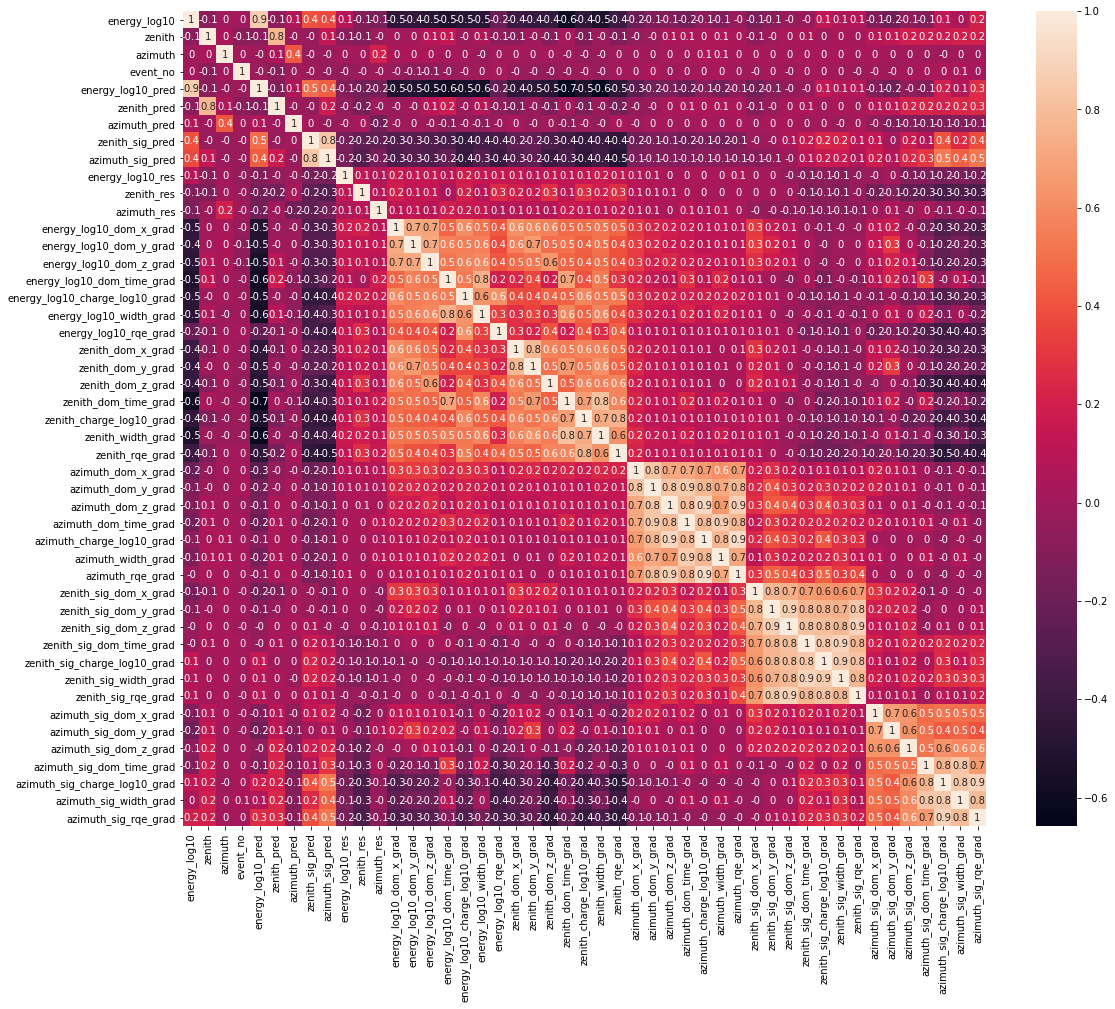

In [219]:
fig, ax = plt.subplots(figsize=(18,15))
corr=df_all.corr()
ax=sns.heatmap(corr, ax=ax, annot=np.round(corr,1))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

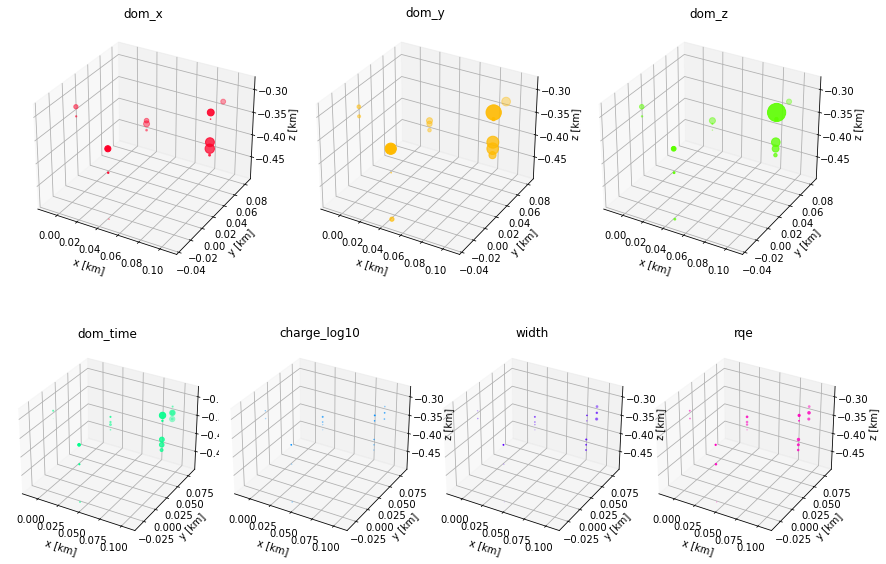

In [12]:
# %matplotlib notebook
%matplotlib inline
k=15
ev, E=event_feats[k], E_grads[k]

axd = plt.figure(figsize=(15,10), constrained_layout=False).subplot_mosaic(
    """
    111122223333
    444555666777
    """
,subplot_kw={"projection": "3d"})
features=["dom_x", "dom_y", "dom_z", "dom_time", "charge_log10", "width", "rqe"]

import matplotlib.cm as mplcm
import matplotlib.colors as colors
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=6)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(7):
    i_s=str(i+1)
    axd[i_s].scatter(ev[:,0],ev[:,1], ev[:,2], c=scalarMap.to_rgba(i), s=(abs(E[:,i])*100))
    axd[i_s].set(xlabel='x [km]', ylabel='y [km]', zlabel='z [km]', title=features[i])

In [13]:
# [rawE,rawzeni,rawazi,rawzenisig,rawazisig], 
# [gradsE, gradszeni,gradsazi,gradszenisig,gradsazisig], targets, predictions, inputs

In [14]:
# split to all
all_grads=[]
all_feats=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        raw_g=np.vstack(raw_g1)
        all_grads.append(raw_g)
#     event_raw_grads1.append(raw_g)
    feat =  np.split(inputs[i][0].numpy(), idx[1:])
    feat=np.vstack(feat)
    all_feats.append(feat)
all_feats=np.vstack(all_feats)
all_grads=np.vstack(all_grads)
# E_grads=np.hstack(E_grads)


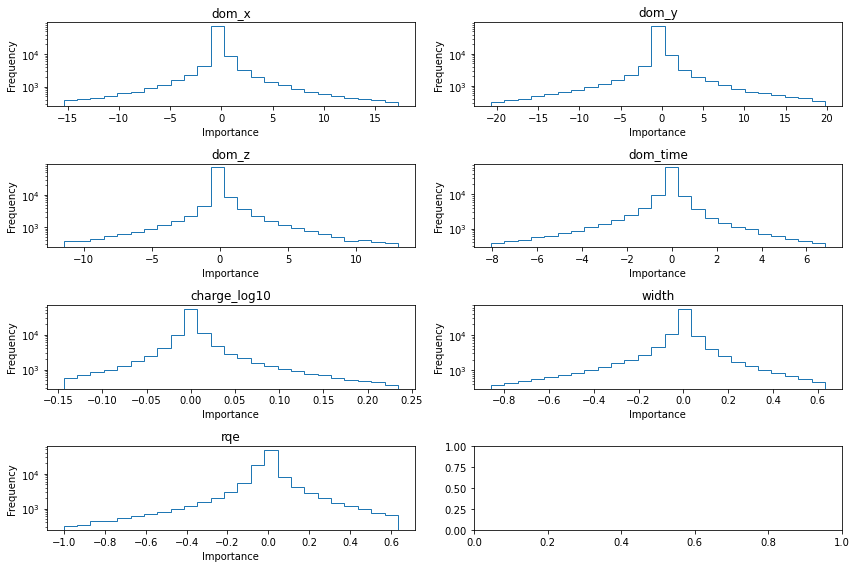

In [15]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_grads[:,i], bins=25, histtype='step', range=(np.percentile(all_grads[:,i], 5),np.percentile(all_grads[:,i], 95)))
    ax[i].set(xlabel='Importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [16]:
# split to all
all_gradsn=[]
for i in tqdm(range(len(raw))):
    _, idx =np.unique(inputs[i][2].numpy(), return_index=True)
#     grad_event=[]
    for j in range(len(raw[0])):
        raw_g1 = np.split(raw[i][j].numpy(),  idx[1:])
        for k in range(len(raw_g1)):
            raw_g1[k]=raw_g1[k]/(np.sum(np.abs(raw_g1[k])))
        raw_g=np.vstack(np.abs(raw_g1))
        all_gradsn.append(raw_g)
all_gradsn=np.vstack(all_gradsn)
# E_grads=np.hstack(E_grads)


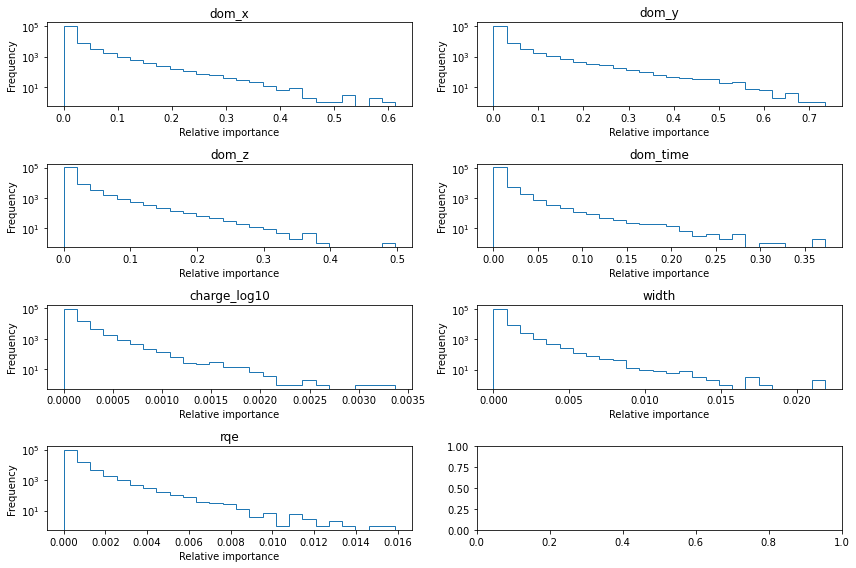

In [17]:
fig,ax=plt.subplots(ncols=2, nrows=4, figsize=(12,8))
ax=ax.flatten()
for i in range(7):
    ax[i].hist(all_gradsn[:,i], bins=25, histtype='step', range=(0,np.max(all_gradsn[:,i])))
    ax[i].set(xlabel='Relative importance', ylabel='Frequency', title=features[i], yscale='log')
    
fig.tight_layout()

In [18]:
import pandas as pd
allfeatdf=pd.DataFrame(all_feats)
allfeatdf.columns=features

In [126]:
# import seaborn as sns
# pl = sns.pairplot(allfeatdf.iloc[:10000], diag_kind='kde', corner=True,
#             x_vars=features[:5], y_vars=features)
# pl.map_lower(sns.kdeplot, levels=4, color=".2")

In [90]:
featg=[feat+'_grad' for feat in features]
dfE=pd.DataFrame(np.vstack(E_grads), columns=featg)
# dfE=dfE[dfE]
for col in dfE.columns:
    dfE=dfE.query(f"{col} != 0")
    dfEfeat=pd.concat([dfE, allfeatdf], axis=1, join='inner')
dfz=pd.DataFrame(np.vstack(z_grads), columns=featg)
for col in dfz.columns:
    dfz=dfz.query(f"{col} != 0")
    dfzfeat=pd.concat([dfz, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfa.columns:
    dfa=dfa.query(f"{col} != 0")
    dfafeat=pd.concat([dfa, allfeatdf], axis=1, join='inner')
dfzs=pd.DataFrame(np.vstack(zs_grads), columns=featg)
dfas=pd.DataFrame(np.vstack(as_grads), columns=featg)
for col in dfzs.columns:
    dfzs=dfzs.query(f"{col} != 0")
    dfzsfeat=pd.concat([dfzs, allfeatdf], axis=1, join='inner')
dfa=pd.DataFrame(np.vstack(a_grads), columns=featg)
for col in dfas.columns:
    dfas=dfas.query(f"{col} != 0")
    dfasfeat=pd.concat([dfas, allfeatdf], axis=1, join='inner')

In [127]:
# plE = sns.pairplot(dfE, diag_kind='kde', corner=True,
#             x_vars=featg, y_vars=featg)
# # plE.map_lower(sns.kdeplot, levels=4, color=".2")

In [128]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features[:-2]+featg[:-2], y_vars=features[:-2]+featg[:-2])

In [129]:
# plE = sns.pairplot(dfEfeat, diag_kind='kde', corner=True, x_vars=features, y_vars=featg)

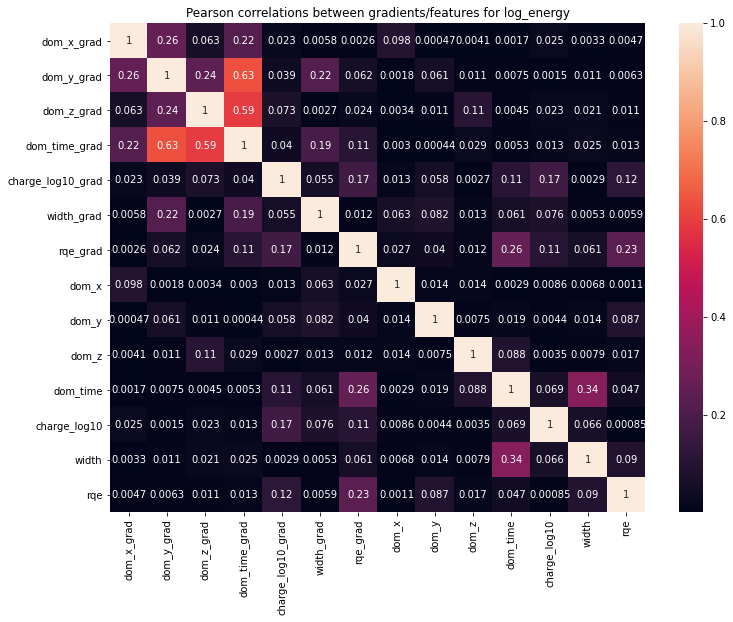

In [125]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfEfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for log_energy')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

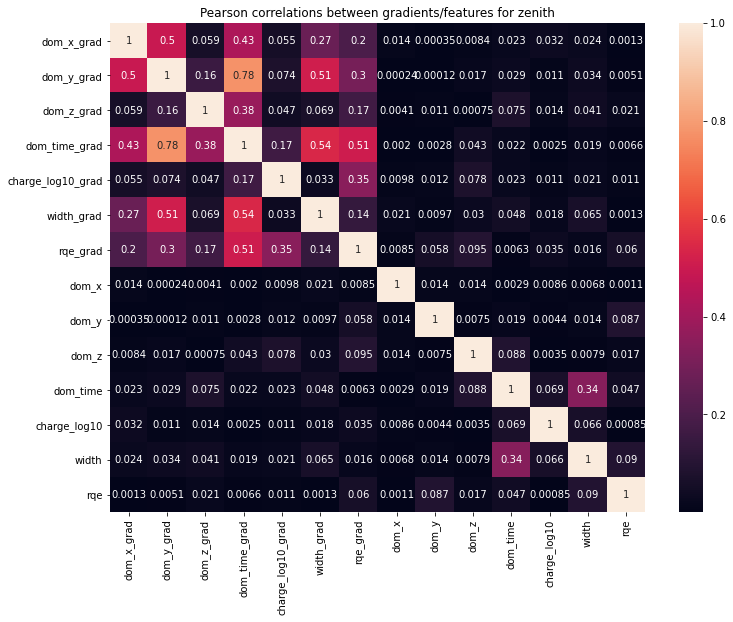

In [123]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith')
fig.savefig('../../figs_thesis/corr_gradfeat_ze.pdf')

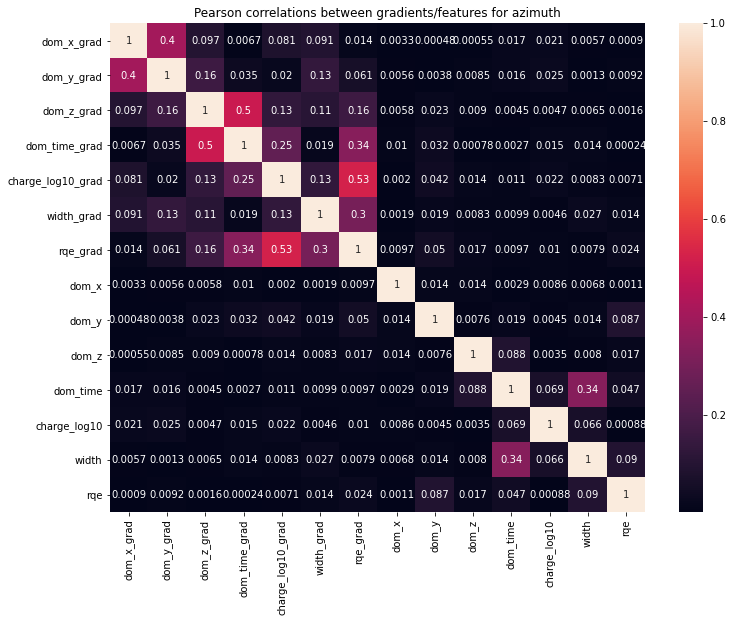

In [124]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfafeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

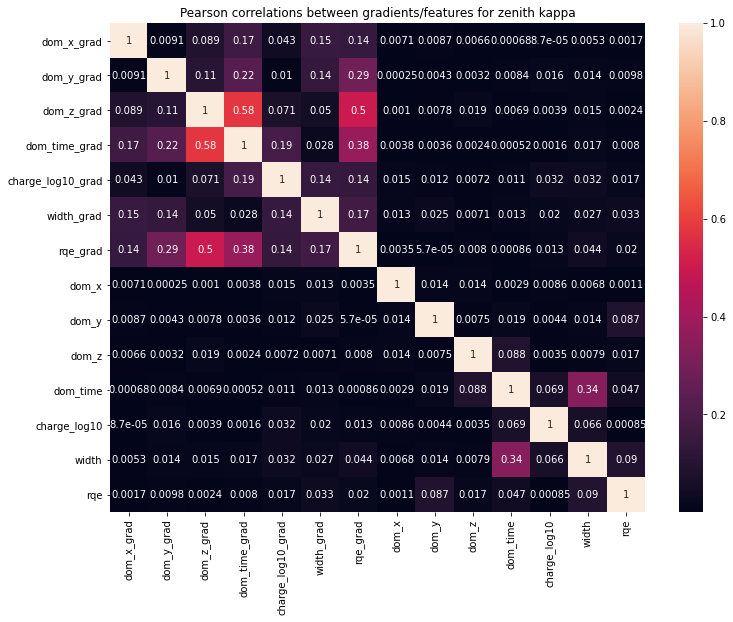

In [122]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfzsfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for zenith kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_zekappa.pdf')

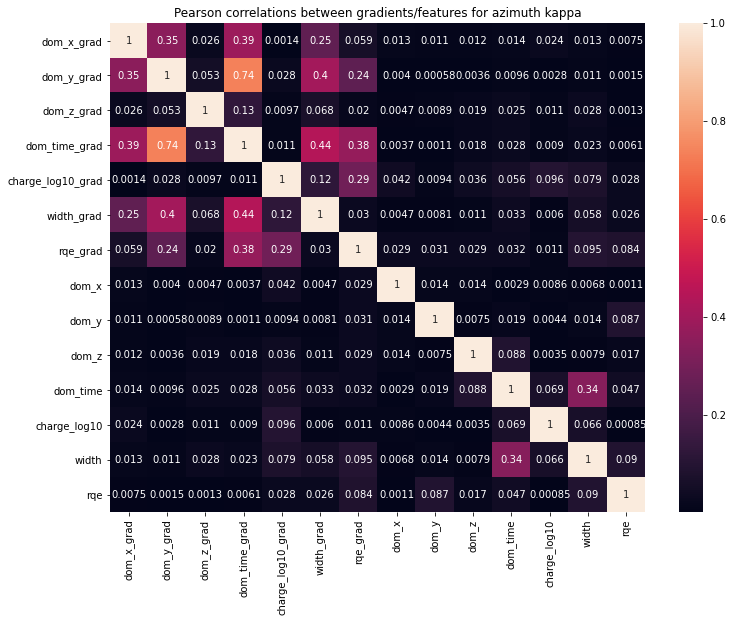

In [121]:
fig, ax=plt.subplots(figsize=(12,9))
ax=sns.heatmap(abs(dfasfeat.corr()), ax=ax, annot=True)
ax.set(title='Pearson correlations between gradients/features for azimuth kappa')
fig.savefig('../../figs_thesis/corr_gradfeat_azkappa.pdf')

In [109]:
mask = np.zeros_like(dfasfeat.corr())
mask[np.triu_indices_from(mask)] = True
mask[:,-7:]=True

In [ ]:
plz = sns.pairplot(dfz, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plz.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
pla = sns.pairplot(dfa, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# pla.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plzs = sns.pairplot(dfzs, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plzs.map_lower(sns.kdeplot, levels=4, color=".2")

In [ ]:
plas = sns.pairplot(dfas, diag_kind='kde', corner=True,
            x_vars=features, y_vars=features)
# plas.map_lower(sns.kdeplot, levels=4, color=".2")

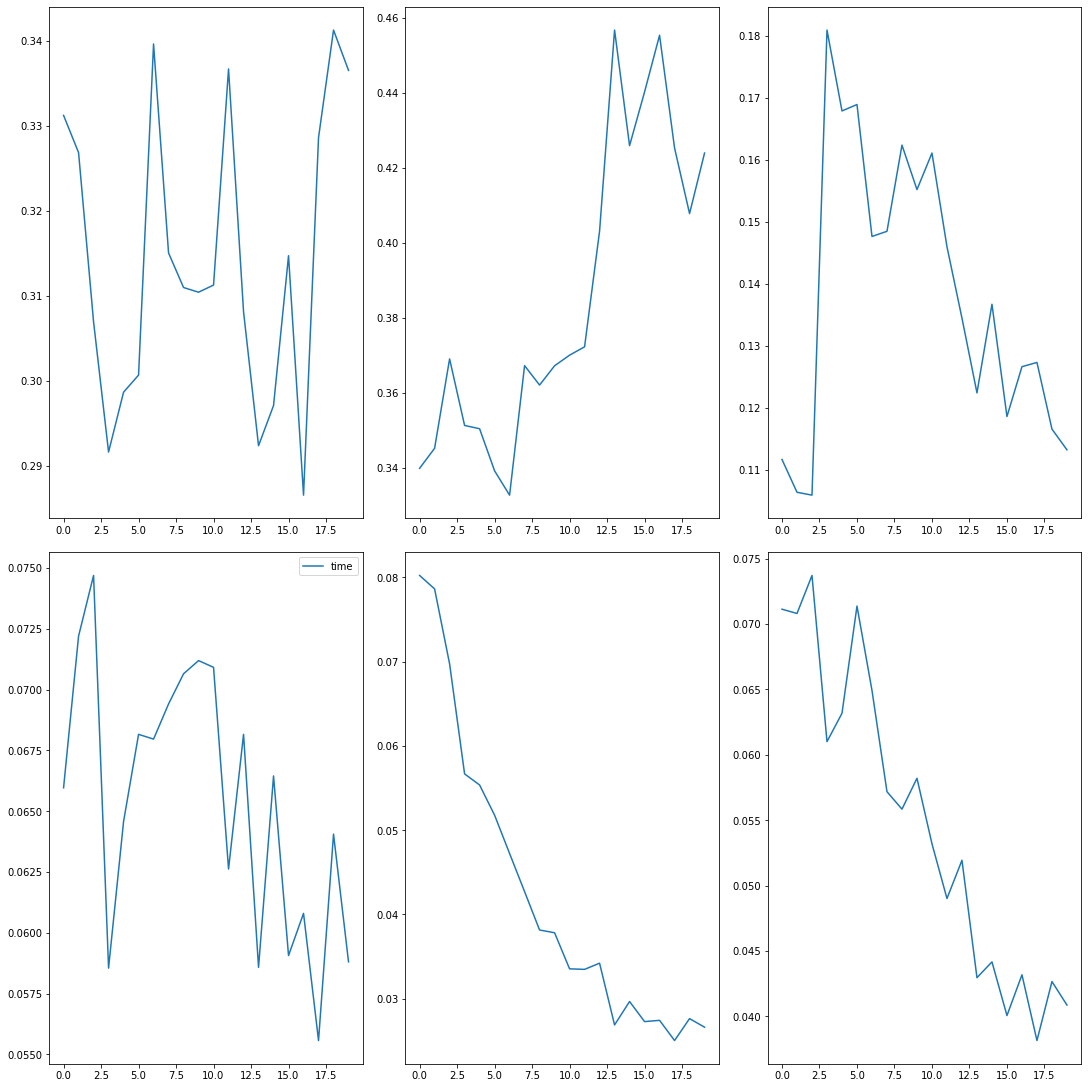

In [31]:
domx=summary[:,0]

ax = plt.figure(constrained_layout=True, figsize=(15,15)).subplot_mosaic(
    [['dom_x', 'dom_y', 'dom_z'],
    ['time', 'charge', 'SRT']])

ax['dom_x'].plot(summary[:,0],label='dom_x')
ax['dom_y'].plot(summary[:,1], label='dom_y')
ax['dom_z'].plot(summary[:,2], label='dom_z')
ax['time'].plot(summary[:,3], label='time')
ax['charge'].plot(summary[:,4], label='charge')
ax['SRT'].plot(summary[:,5], label='SRT')
plt.legend()

In [37]:
grad_dict={'energy':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
           'zenith':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'azimuth':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_zeni':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1},
          'sig_azi':{'dom_x':1,
          'dom_y':1,
          'dom_z':1,
          'time':1,
          'logcharge':1,
          'SRT':1}}

In [46]:
feats=list(grad_dict[keys[0]].keys())